In [42]:
import sys
import pandas as pd
from datatransformer import DataTransformerDeep
sys.path.insert(0, 'C:/Udvikler/Speciale/SpecialeKode')
from utils import *
from model_evaluation.RFQModelEval import RFQModelEval, eval_utils
from DeepRFQAgent import DeepRFQAgent
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # For boxplot legend entries
import matplotlib.lines as mlines  # For axhline legend entry
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [43]:
#Configs 

sample_methods = [
    #"random",
    "time_biased"
]

alphas = [#"0.25",
          "0.5",
          #"0.75"
        ]


all_features = [
    #["bpv_risk", "Duration", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    ["bpv_risk", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["bpv_risk", "delta_h_t", "Duration", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["bpv_risk","delta_h_t", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["bpv_risk", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["inventoryRisk", "Duration", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    ["inventoryRisk", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["inventoryRisk", "delta_h_t", "Duration", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["inventoryRisk", "delta_h_t", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    ["inventoryRisk", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"]
]

all_reward_functions = [
    inventory_PnL_reward,
    risk_PnL_reward,
    #hitrate_target_reward,
    #linearMarginReward,
    #quadraticMarginReward
]

learning_algorithms = [
    'random_by_action_distr',
    'random_by_uniform',
    'CQL'
]

metrics = ["dealerHitRate", "mlHitRate", "MLWinShare", "mlDistToCoverMean", "mlDistToCoverStd", "dealerDistToCoverMean", 
           "meanMLProfit", "meanDealerProfit", "meanRLReward", "dealerD2TargetMean", "MLD2TargetMean", "MLD2TargetStd",
           "meanMLSharpeRatio", "meanDealerSharpeRatio", "meanDealerSharpeRatioNoNeg", "DealerNetInventoryDiff", "MLNetInventoryDiff"]

# Convert each list of features to a single concatenated string
all_features_str = [",".join(features) for features in all_features]  # Join list of strings with commas

# Create a MultiIndex for the DataFrame using the combinations of parameters
index = pd.MultiIndex.from_tuples(
    [(features, reward_function.__name__, learning_algorithm, sample_method, alpha)
     for features, reward_function, learning_algorithm, sample_method, alpha in 
     itertools.product(all_features_str, all_reward_functions, learning_algorithms, sample_methods, alphas)
     if (("bpv_risk" not in features or reward_function.__name__ != "inventory_PnL_reward") and 
         ("inventoryRisk" not in features or reward_function.__name__ != "risk_PnL_reward") and
         (("delta_h_t" in features and reward_function.__name__ == "hitrate_target_reward") or
             ("delta_h_t" not in features and reward_function.__name__ != "hitrate_target_reward")))],
    names=["Features", "Reward Function", "Learning Algorithm", "Sample method", "Alpha"]
)

In [44]:
all_results = []

for idx in index:

    
    file_path = f"experiments_PnLs/results_{idx[0]}_{idx[1]}_{idx[2]}_{idx[3]}_{idx[4]}.csv"
  
    if not os.path.exists(file_path):
        print(f"Warning: Results file not found for {idx}. Skipping.")
        continue  # Skip missing file
    
    trial_data = pd.read_csv(file_path)  # Load stored trial data

    # Extract relevant parts of the key
    features_key = idx[0].split(",")[0]  # Get the first feature from the feature list
    reward_function_key = idx[1]         # Reward function name
    algorithm_key = idx[2]               # Algorithm name
    
    features = idx[0].split(",")
    if "Amount" in features:
        features_key += "_Amount"
    
    # Create a simplified combination label
    if algorithm_key in ['random_by_action_distr', 'random_by_uniform']:
        # For random policies, use only the algorithm name
        simplified_key = algorithm_key
    else:
        # For other algorithms, include first feature, reward function, and algorithm
        simplified_key = f"{features_key}_{reward_function_key}_{algorithm_key}"

    trial_data['Combination'] = simplified_key  # Add the simplified label
    all_results.append(trial_data)
    
# Concatenate all results into a single DataFrame
all_results_df = pd.concat(all_results, ignore_index=True)

In [45]:
print(index)
all_results_df['Combination'].unique()

MultiIndex([(     'bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid', ...),
            (     'bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid', ...),
            (     'bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid', ...),
            ('inventoryRisk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid', ...),
            ('inventoryRisk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid', ...),
            ('inventoryRisk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid', ...),
            (                'inventoryRisk,Side,DealersInCompetition,BookName,AllQMeanMid', ...),
            (                'inventoryRisk,Side,DealersInCompetition,BookName,AllQMeanMid', ...),
            (                'inventoryRisk,Side,DealersInCompetition,BookName,AllQMeanMid', ...)],
           names=['Features', 'Reward Function', 'Learning Algorithm', 'Sample method', 'Alpha'])


array(['bpv_risk_Amount_risk_PnL_reward_CQL',
       'inventoryRisk_Amount_inventory_PnL_reward_CQL',
       'random_by_action_distr', 'random_by_uniform'], dtype=object)

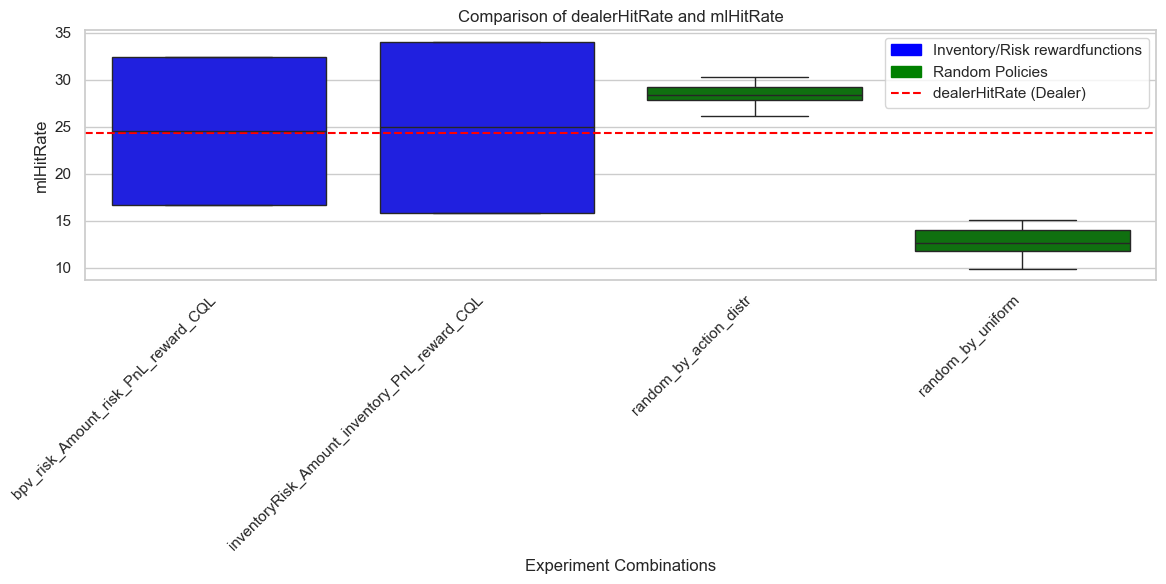

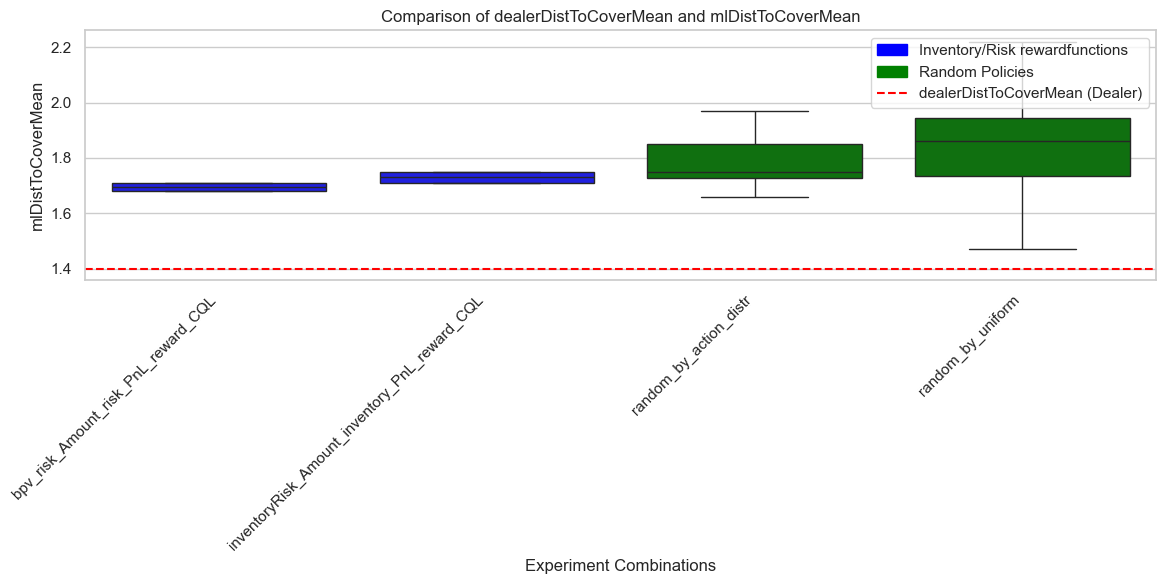

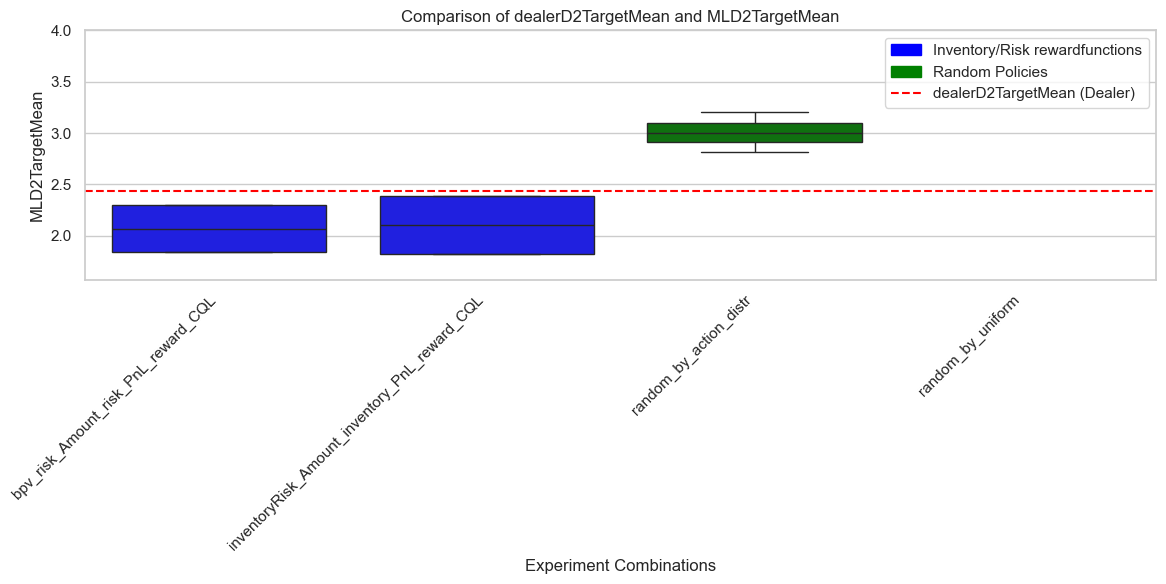

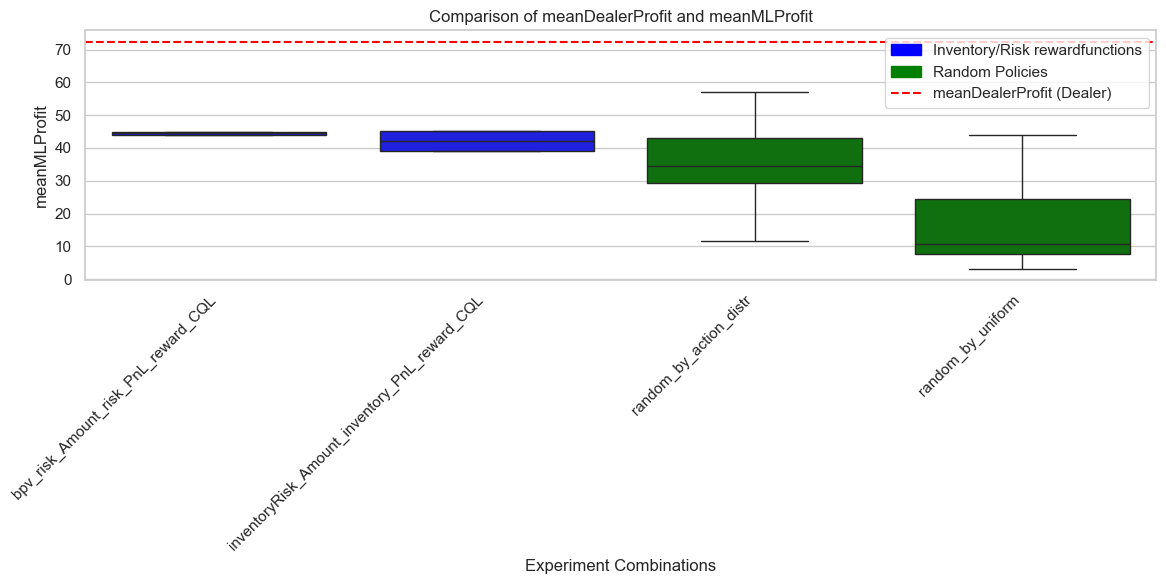

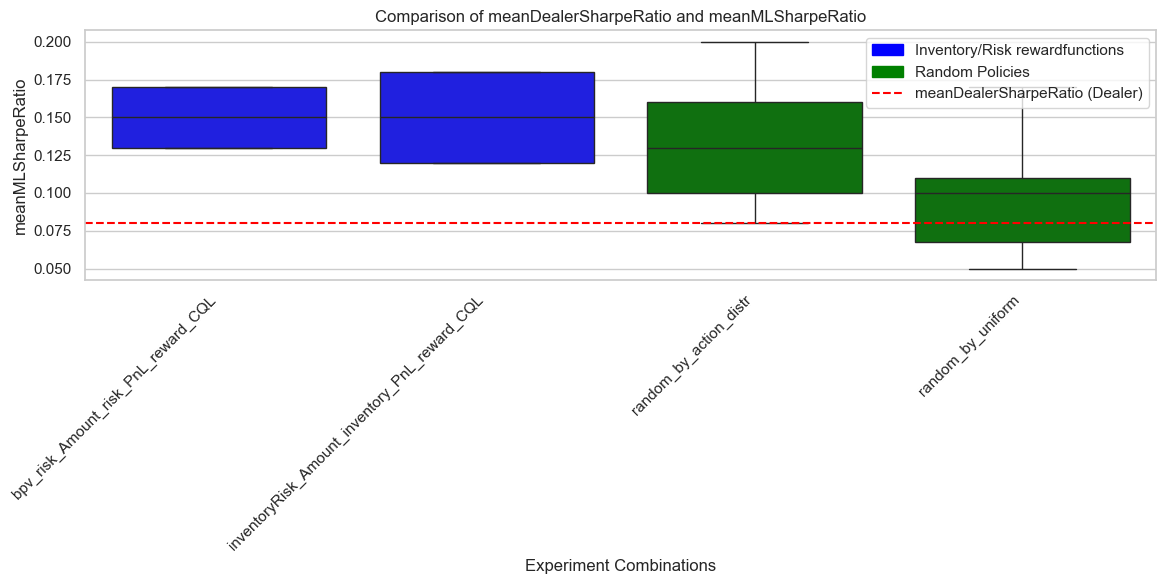

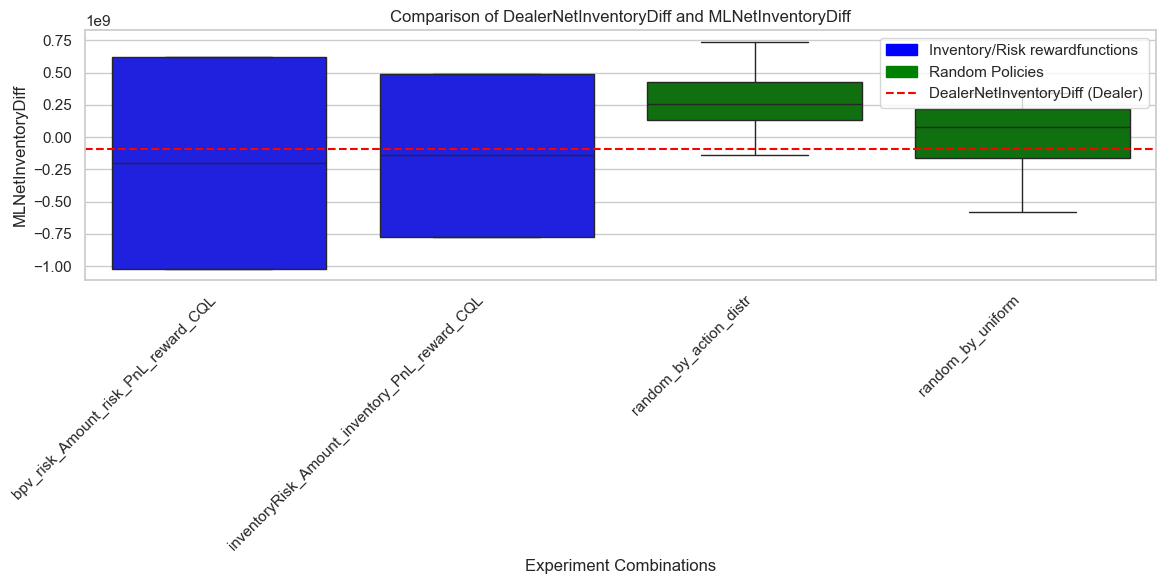

In [46]:
# Separate metrics into ML and Dealer pairs
metrics = [
    ("dealerHitRate", "mlHitRate"), 
    ("dealerDistToCoverMean", "mlDistToCoverMean"),
    ("dealerD2TargetMean", "MLD2TargetMean"),
    ("meanDealerProfit", "meanMLProfit"),
    ("meanDealerSharpeRatio", "meanMLSharpeRatio"),
    ("DealerNetInventoryDiff", "MLNetInventoryDiff")
]

sns.set_theme(style="whitegrid")

# Define custom colors
reward_colors = {'linearMarginReward': 'orange', 'quadraticMarginReward': 'purple', 'hitrate_target_reward': 'brown'}
default_color = 'blue'  # Default boxplot color for DQN configurations
random_color = 'green'  # Color for random policies

# Assign colors based on combination
palette = {}
for combination in all_results_df['Combination'].unique():
    if 'random_by_action_distr' in combination or 'random_by_uniform' in combination:
        palette[combination] = random_color
    elif 'linearMarginReward' in combination:
        palette[combination] = reward_colors['linearMarginReward']
    elif 'quadraticMarginReward' in combination:
        palette[combination] = reward_colors['quadraticMarginReward']
    elif 'hitrate_target_reward' in combination:
        palette[combination] = reward_colors['hitrate_target_reward']
    else:
        palette[combination] = default_color

# Determine the order of combinations for grouped colors
ordered_combinations = sorted(palette, key=lambda x: palette[x])

# Plotting loop
for dealer_metric, ml_metric in metrics:
    plt.figure(figsize=(12, 6))
    
    # Boxplot for ML metrics
    sns.boxplot(
        data=all_results_df, 
        x="Combination", 
        y=ml_metric, 
        palette=[palette[comb] for comb in ordered_combinations],  # Use ordered colors
        order=ordered_combinations,  # Group by color
        showfliers=False,
        hue="Combination",
        legend=False
    )
    
    # Overlay dealer metric as a horizontal line
    dealer_value = all_results_df[f"{dealer_metric}"].mean()
    axhline = plt.axhline(
        y=dealer_value, 
        color='red', 
        linestyle='--', 
        label=f"{dealer_metric} (Dealer)"
    )

    if ml_metric == 'MLD2TargetMean':
        #plt.yscale('log')
        plt.ylim(top=4.0)

    # Add a custom legend for boxplot colors and dealer line
    legend_patches = [
        mpatches.Patch(color=default_color, label='Inventory/Risk rewardfunctions'),
        mpatches.Patch(color=random_color, label='Random Policies'),
        #mpatches.Patch(color=reward_colors['linearMarginReward'], label='Linear Margin Reward'),
        #mpatches.Patch(color=reward_colors['quadraticMarginReward'], label='Quadratic Margin Reward'),
        #mpatches.Patch(color=reward_colors['hitrate_target_reward'], label='Hitrate and Margin Reward'),
        mlines.Line2D([], [], color='red', linestyle='--', label=f"{dealer_metric} (Dealer)")
    ]
    plt.legend(handles=legend_patches, loc="upper right")
    
    # Set plot title and labels
    plt.title(f"Comparison of {dealer_metric} and {ml_metric}")
    plt.xlabel("Experiment Combinations")
    plt.ylabel(ml_metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Show plot
    plt.show()
